# FoCus Dataset

In [1]:
DATASET = "FoCus"
SET = "train"           #train,   valid   

In [2]:
import pandas as pd
import json

with open(f'./datasets/{DATASET}/{SET}_focus.json') as f:
    data = json.load(f)

In [3]:
def convertToDialogue(my_list):
    formatted_string = ""
    for index, item in enumerate(my_list):
        if index % 2 == 0:
            user = "User1"
        else:
            user = "User2"
        formatted_string += f"{user}: {item}\n"
    formatted_string = formatted_string.rstrip("\n")
    return formatted_string

flattened_data = []
data_list = data['data']
for entry in data_list:
    persona =  "".join(entry['persona'])
    list_length = len(entry["utterance"])
    last_utterance = entry["utterance"][-1]
    dialogue_key = f"dialogue{list_length}"
    last_item = last_utterance[dialogue_key]
    flattened_data.append({
                'dialogID': entry['dialogID'],
                'persona': persona,
                'utterance': convertToDialogue(last_item)
            })

dataset = pd.DataFrame(flattened_data)
print(dataset.shape)

(12484, 3)


In [4]:
if SET == "train":
    # Randomly select 1500 rows
    df = dataset.sample(n=4000, random_state=42)
    print("\nMissing? Values:\n", df.isnull().sum())
else:
    df = dataset


Missing? Values:
 dialogID     0
persona      0
utterance    0
dtype: int64


In [5]:
df = df.replace(r'\*\*', '', regex=True)
df = df.replace(r'\r', '', regex=True)
df = df.replace("'", "", regex=True)

df.dropna(inplace=True)

# Function to split the conversation
def split_conversation(conv_str):
    utterances = conv_str.split("\n")
    context = "\n".join(utterances[:-1])
    response = utterances[-1]
    return context, response

new_rows = []
for index, row in df.iterrows():
    context, response = split_conversation(row['utterance'])
    new_row = {
        'personas': row['persona'],
        'context': context,
        'act_response': response
    }
    new_rows.append(new_row)

new_df = pd.DataFrame(new_rows)

print(new_df.shape)
new_df.head(10)

(4000, 3)


,personas,context,act_response
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",User2: You can access Descent of the Ganges vi...
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",User2: It was Sherman School.
2,I love cool lakes.I would like to visit the Hi...,"User1: I know this place, but I dont remember ...",User2: It formed from being a tributary of the...
3,I prefer outdoor stadium over indoor stadium.I...,User1: Where is this place?\nUser2: This place...,User2: I just remembered that you are interest...
4,I would like to visit Spain.I am interested in...,User1: Where is this place?\nUser2: This is Ur...,User2: Urdaibai Bird Center deals with two mai...
5,I would like to visit Hawaiʻi.I am interested ...,"User1: Wow, this is amazing! What is this?\nUs...",User2: Mauna Kea has an alpine climate and tem...
6,I dont like war.I love visiting memorials.I wo...,"User1: Wow, this is amazing! What is this?\nUs...","User2: Yes it is, as well as the park it sits ..."
7,I would like to visit Jerusalem.I like to visi...,User1: Where is this place?\nUser2: This is th...,User2: This museum shows items that tells of t...
8,I am going to travel to visit friends in Orego...,User1: I think Ive been there before but I don...,"User2: This is a good question, so you can pre..."
9,I live in baltimore.I am not from Maryland.I w...,"User1: I know this place, but I dont remember ...",User2: The center is owned by The City of Balt...


In [6]:
# Calculate minimum and maximum number of words in each column
min_persona_length = new_df['personas'].apply(lambda x: len(x.split())).min()
max_persona_length = new_df['personas'].apply(lambda x: len(x.split())).max()

min_context_length = new_df['context'].apply(lambda x: len(x.split())).min()
max_context_length = new_df['context'].apply(lambda x: len(x.split())).max()

min_response_length = new_df['act_response'].apply(lambda x: len(x.split())).min()
max_response_length = new_df['act_response'].apply(lambda x: len(x.split())).max()

# Print the lengths in min-max format
print(f"Persona Length (in words): {min_persona_length}-{max_persona_length}")
print(f"Context Length (in words): {min_context_length}-{max_context_length}")
print(f"Response Length (in words): {min_response_length}-{max_response_length}")

Persona Length (in words): 11-92
Context Length (in words): 46-603
Response Length (in words): 3-146


In [7]:
print(new_df.isnull().sum())

new_df.dropna(inplace=True)

# Save the prompts
new_df.to_csv(f'./Prompts/{DATASET}-{SET}.csv', index=False)

new_df.head(2)

personas        0
context         0
act_response    0
dtype: int64


,personas,context,act_response
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",User2: You can access Descent of the Ganges vi...
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",User2: It was Sherman School.


# DPO Dataset

## Set parameters

In [11]:
DATASET = "FoCus"

LLM_names = [
    # "Qwen2-7B-Instruct",
    "Qwen2-5B-Instruct",
]

_COT = ""                       # "", "-COT"

SCORING_METHOD = "Length Prioritization"          # AVG, Length Prioritization   


## Failed Responses

In [12]:
import pandas as pd
import os

# Load the shared prompt data (same for all LLMs)
prompt_path = os.path.join("Prompts", f"{DATASET}-train.csv")
try:
    prompt_df = pd.read_csv(prompt_path)
    print(f"Loaded prompt data | Shape: {prompt_df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Prompt file not found: {prompt_path}")

# Directory where LLM outputs are stored
base_dir = os.path.join("Raw Responses", DATASET)

# Container for all model outputs (with prompts merged)
all_dfs = []

# Load and horizontally merge prompt data for each LLM file
for LLM_name in LLM_names:
    file_path = os.path.join(base_dir, f"{LLM_name}-train{_COT}.csv")
    try:
        df = pd.read_csv(file_path)
        if len(df) != len(prompt_df):
            raise ValueError(f"❌ Mismatch in rows: {LLM_name}-train{_COT}.csv has {len(df)} rows, but prompt file has {len(prompt_df)}.")
        
        df = pd.concat([prompt_df, df], axis=1)  # Horizontal merge
        df["source_model"] = LLM_name + _COT     # Track source model
        print(f" Merged: {LLM_name}-train{_COT}.csv | New shape: {df.shape}")
        all_dfs.append(df)
    except FileNotFoundError:
        print(f"❌ File not found: {LLM_name}-train{_COT}.csv")

# Vertically combine all model data
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("\n Final Combined DataFrame shape:", combined_df.shape)
    display(combined_df.head(3))
else:
    print("\n⚠️ No files loaded. combined_df will not exist.")


Loaded prompt data | Shape: (4000, 3)
 Merged: Qwen2-5B-Instruct-train.csv | New shape: (4000, 6)

 Final Combined DataFrame shape: (4000, 6)


,personas,context,act_response,gen_response,response_time,source_model
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",User2: You can access Descent of the Ganges vi...,Note: The response should not contain any pers...,0.790489,Qwen2-5B-Instruct
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",User2: It was Sherman School.,Note: You may need to add additional details i...,0.744353,Qwen2-5B-Instruct
2,I love cool lakes.I would like to visit the Hi...,"User1: I know this place, but I dont remember ...",User2: It formed from being a tributary of the...,Note: The response should be personal and tail...,0.895105,Qwen2-5B-Instruct


In [13]:
import json
import re
import pandas as pd

def clean_gen_response_with_status(cell):
    if not isinstance(cell, str):
        return None, False

    # Step 1: Try full JSON parsing
    json_objects = re.findall(r'\{.*?\}', cell, re.DOTALL)
    for obj in json_objects:
        try:
            parsed = json.loads(obj)
            if "response" in parsed:
                return parsed["response"], True  # ✅ Successfully parsed JSON
        except json.JSONDecodeError:
            continue

    # Step 2: Fallback - Extract string after '"response": "'
    match = re.search(r'"response"\s*:\s*"(.*)', cell, re.DOTALL)
    if match:
        fallback_text = match.group(1)

        # Clean fallback text
        fallback_text = fallback_text.strip('"\n{} ').rstrip('.… ').strip()

        return fallback_text, False  # ❌ Not valid JSON, but usable fallback

    return None, False  # Nothing usable found

# Apply the function
combined_df[["cleaned_response", "json_success"]] = combined_df["gen_response"].apply(
    lambda x: pd.Series(clean_gen_response_with_status(x))
)

# Add word count
combined_df["response_word_count"] = combined_df["cleaned_response"].apply(
    lambda x: len(str(x).split()) if x else 0
)


In [14]:
# Count how many rows have cleaned_response == None
none_count = combined_df["cleaned_response"].isnull().sum()
print(f"Number of None values in 'cleaned_response': {none_count}")


Number of None values in 'cleaned_response': 317


In [15]:
# Drop rows with missing cleaned responses
combined_df = combined_df.dropna(subset=["cleaned_response"])

In [16]:
print("Successful responses:", len(combined_df[combined_df['json_success'] == True]))

print("Failed responses:", len(combined_df[combined_df['json_success'] == False]))

combined_df[combined_df['json_success'] == False].head(4)

Successful responses: 2464
Failed responses: 1219


,personas,context,act_response,gen_response,response_time,source_model,cleaned_response,json_success,response_word_count
2,I love cool lakes.I would like to visit the Hi...,"User1: I know this place, but I dont remember ...",User2: It formed from being a tributary of the...,Note: The response should be personal and tail...,0.895105,Qwen2-5B-Instruct,It sounds like you're planning on visiting the...,False,69
4,I would like to visit Spain.I am interested in...,User1: Where is this place?\nUser2: This is Ur...,User2: Urdaibai Bird Center deals with two mai...,Note: The response should not contain any pers...,0.898532,Qwen2-5B-Instruct,Urdaibai Bird Center is a unique bird sanctuar...,False,64
6,I dont like war.I love visiting memorials.I wo...,"User1: Wow, this is amazing! What is this?\nUs...","User2: Yes it is, as well as the park it sits ...",Note: Please include all necessary elements in...,0.900168,Qwen2-5B-Instruct,The Boer War Memorial is a significant landmar...,False,54
8,I am going to travel to visit friends in Orego...,User1: I think Ive been there before but I don...,"User2: This is a good question, so you can pre...",Note: The response should be personal and tail...,0.902223,Qwen2-5B-Instruct,"Sure, I'd be happy to help you plan your trip ...",False,62


In [17]:
# Step 1: Keep only rows with unsuccessful JSON parsing
rejected_df = combined_df[combined_df["json_success"] == False].copy()

rejected_df.drop(columns=["gen_response", "source_model", "json_success", "response_word_count"], inplace=True)

rejected_df.rename(columns={"cleaned_response": "gen_response"}, inplace=True)

# Step 2: Add default evaluation columns
rejected_df["Coh-UniEval"] = 0.0
rejected_df["C Score"] = -1
rejected_df["UE Score"] = 0
rejected_df["Persona Distance"] = 0.0

# Optional: View result
print(f"✅ Filtered DataFrame shape: {rejected_df.shape}")

print("Columns:", rejected_df.columns)
display(rejected_df.head())

✅ Filtered DataFrame shape: (1219, 9)
Columns: Index(['personas', 'context', 'act_response', 'response_time', 'gen_response',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')


,personas,context,act_response,response_time,gen_response,Coh-UniEval,C Score,UE Score,Persona Distance
2,I love cool lakes.I would like to visit the Hi...,"User1: I know this place, but I dont remember ...",User2: It formed from being a tributary of the...,0.895105,It sounds like you're planning on visiting the...,0.0,-1,0,0.0
4,I would like to visit Spain.I am interested in...,User1: Where is this place?\nUser2: This is Ur...,User2: Urdaibai Bird Center deals with two mai...,0.898532,Urdaibai Bird Center is a unique bird sanctuar...,0.0,-1,0,0.0
6,I dont like war.I love visiting memorials.I wo...,"User1: Wow, this is amazing! What is this?\nUs...","User2: Yes it is, as well as the park it sits ...",0.900168,The Boer War Memorial is a significant landmar...,0.0,-1,0,0.0
8,I am going to travel to visit friends in Orego...,User1: I think Ive been there before but I don...,"User2: This is a good question, so you can pre...",0.902223,"Sure, I'd be happy to help you plan your trip ...",0.0,-1,0,0.0
17,I would like to visit the Bronx.I have been to...,"User1: I know this place, but I dont remember ...","User2: In recent years, this neighborhood has ...",0.899753,The user seems to be interested in visiting th...,0.0,-1,0,0.0


In [18]:
# First get unique context-persona pairs
rejected_unique_pairs = rejected_df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(rejected_unique_pairs)}")

rejected_unique_pairs

Total unique context-persona pairs: 1217


,personas,context
2,I love cool lakes.I would like to visit the Hi...,"User1: I know this place, but I dont remember ..."
4,I would like to visit Spain.I am interested in...,User1: Where is this place?\nUser2: This is Ur...
6,I dont like war.I love visiting memorials.I wo...,"User1: Wow, this is amazing! What is this?\nUs..."
8,I am going to travel to visit friends in Orego...,User1: I think Ive been there before but I don...
17,I would like to visit the Bronx.I have been to...,"User1: I know this place, but I dont remember ..."
...,...,...
3983,I work with petroleum.I study geologic formati...,"User1: I know this place, but I dont remember ..."
3984,I would like to visit USA.I am interested in p...,"User1: Wow, this is amazing! What is this?\nUs..."
3988,I would like to have a picnic in Glasgow Green...,User1: Where is this place?\nUser2: This place...
3993,I love Spanish.I have a picture of San Juan Ca...,"User1: I know this place, but I dont remember ..."


## Sucessful Responses

In [19]:
import pandas as pd

all_dfs = []  # List to store all dataframes

for llm in LLM_names:
    # Read the Excel file for each LLM
    ds = pd.read_excel(f"Metrics Results/{DATASET}/{llm}-train{_COT}-results.xlsx")

    all_dfs.append(ds)

# Combine all dataframes vertically
ds = pd.concat(all_dfs, axis=0, ignore_index=True)
len(ds)

4000

In [20]:
chosen_df = ds.dropna(subset=['gen_response'])

print("Columns:", chosen_df.columns)
print(len(chosen_df))
chosen_df.head(3)

Columns: Index(['personas', 'context', 'act_response', 'gen_response', 'response_time',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')
2464


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",You can access Descent of the Ganges via Chenn...,Hello! Welcome to Descent of the Ganges. It's ...,0.790489,0.998912,1,0,0.430646
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",It was Sherman School.,The name of the place is Little Rock Central H...,0.744353,0.994791,0,2,0.604749
3,I prefer outdoor stadium over indoor stadium.I...,User1: Where is this place?\nUser2: This place...,I just remembered that you are interested in N...,Camp Randall Stadium is an outdoor stadium loc...,0.747605,0.996146,1,0,0.685219


## Dataset Creation

In [21]:
print(chosen_df.isna().sum())

print(rejected_df.isna().sum())

personas            0
context             0
act_response        0
gen_response        0
response_time       0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64
personas            0
context             0
act_response        0
response_time       0
gen_response        0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64


In [22]:
# Concatenate chosen_df and rejected_df vertically
df = pd.concat([chosen_df, rejected_df], ignore_index=True)

# Print information about the operation
print(f"Shape of chosen_df: {chosen_df.shape}")
print(f"Shape of rejected_df: {rejected_df.shape}")
print(f"Shape of combined DataFrame: {df.shape}")

# Display the first few rows of the combined dataframe
df.head()

Shape of chosen_df: (2464, 9)
Shape of rejected_df: (1219, 9)
Shape of combined DataFrame: (3683, 9)


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",You can access Descent of the Ganges via Chenn...,Hello! Welcome to Descent of the Ganges. It's ...,0.790489,0.998912,1,0,0.430646
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",It was Sherman School.,The name of the place is Little Rock Central H...,0.744353,0.994791,0,2,0.604749
2,I prefer outdoor stadium over indoor stadium.I...,User1: Where is this place?\nUser2: This place...,I just remembered that you are interested in N...,Camp Randall Stadium is an outdoor stadium loc...,0.747605,0.996146,1,0,0.685219
3,I would like to visit Hawaiʻi.I am interested ...,"User1: Wow, this is amazing! What is this?\nUs...",Mauna Kea has an alpine climate and temperatur...,Please provide more details about your interes...,0.453596,0.937975,0,1,0.622627
4,I would like to visit Jerusalem.I like to visi...,User1: Where is this place?\nUser2: This is th...,This museum shows items that tells of three pe...,The Seibenberg House is a museum located in Je...,0.711767,0.997056,1,0,0.743786


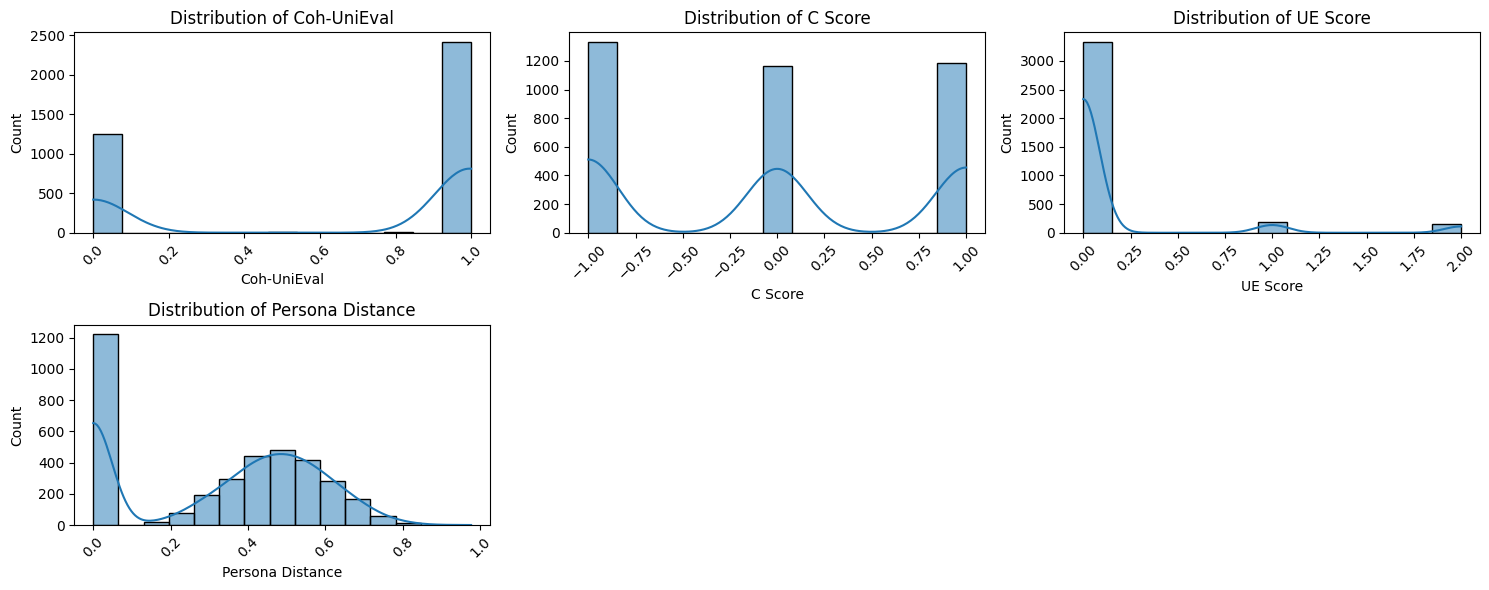

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_analyze = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

plt.figure(figsize=(15, 5*len(columns_to_analyze)//3))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(len(columns_to_analyze)//3 + 1, 3, i)
    sns.histplot(data= df, x=column, kde=True)  # kde=True adds a density curve
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Step 2: Normalize metrics to [0, 1]
metrics = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

scaler = MinMaxScaler()
df[metrics] = scaler.fit_transform(df[metrics])

# Compute response length in number of words
df.rename(columns={"gen_response": "response"}, inplace=True)

df["response_length"] = df["response"].str.split().str.len()

# Set your preferred maximum response length
if _COT == "-COT":
    MAX_LEN = 220
else:
    MAX_LEN = 110

# Compute length penalty (shorter is better)
df["length_penalty"] = 1.0 - (df["response_length"] / MAX_LEN)
df["length_penalty"] = df["length_penalty"].clip(lower=0.0, upper=1.0)


if SCORING_METHOD == "AVG":
    
    # AVG Style
    df["quality_score"] = df[metrics].mean(axis=1)
else:
    
    # Prioritizing the Response Length
    df["quality_score"] = (
        0.15 * df["Coh-UniEval"] +
        0.15 * df["C Score"] +
        0.15 * df["UE Score"] +
        0.15 * df["Persona Distance"] + 
        0.4 * df["length_penalty"]
    )

print("✅ Added normalized quality score:")
display(df[["Coh-UniEval", "C Score", "UE Score", "Persona Distance", "length_penalty", "quality_score"]].head())

df.drop(columns=["Coh-UniEval", "C Score", "UE Score", "Persona Distance", "length_penalty"], inplace=True)

df.drop(columns=["act_response", "response_time", "response_length"], inplace=True)

✅ Added normalized quality score:


,Coh-UniEval,C Score,UE Score,Persona Distance,length_penalty,quality_score
0,0.999167,1.0,0.0,0.441118,0.509091,0.569679
1,0.995045,0.5,1.0,0.619454,0.563636,0.692629
2,0.996400,1.0,0.0,0.701882,0.518182,0.612015
3,0.938214,0.5,0.5,0.637768,0.727273,0.677306
4,0.997310,1.0,0.0,0.761872,0.500000,0.613877


In [25]:
# Function to generate a prompt
def create_dpo_prompt(personas, context, _COT):

    prompt = (
        "I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\n"
        "As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\n"
        "Participant Personas:\n"
        f"{personas}\n\n"
        "Conversation Context:\n"
        f"{context}\n\n"
        "Task Instruction:\n"
        "* Provide an unannotated response.\n"
        "* If only one persona is available, personalize the response accordingly.\n"
        "* If the conversation context is a single query, respond appropriately to the query.\n"
    )
    
    if _COT == "-COT":
        prompt += (
            "* Apply Chain of Thought reasoning to reflect on the alignment of your response with the personas.\n"
        )

    prompt += (
        "\nOutput Format: only give a JSON of the following format:\n"
        "{\n"
    )
    
    if _COT == "-COT":
        prompt += (
            '  "reasoning": "briefly describe your personalization process (in 110 words or less)."\n'
        )
        
    prompt += (
        '  "response": "provide the personalized natural language response here (in 110 words or less)."\n'
        "}\n"
    )

    return prompt

In [26]:
# Step 4: Prepare prompt and extract unique pairs

# # Apply to your dataframe
# df["prompt"] = df.apply(lambda row: create_dpo_prompt(row["personas"], row["context"], _COT), axis=1)

df["prompt"] = df.apply(lambda row: f"Persona: {row['personas']}\nContext: {row['context']}", axis=1)

# Get unique (personas, context) pairs
unique_pairs = df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(unique_pairs)}")

df.head(3)


Total unique context-persona pairs: 3681


,personas,context,response,quality_score,prompt
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",Hello! Welcome to Descent of the Ganges. It's ...,0.569679,Persona: Id like to visit a historic place.I w...
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",The name of the place is Little Rock Central H...,0.692629,Persona: I hope to see some rock in Little Roc...
2,I prefer outdoor stadium over indoor stadium.I...,User1: Where is this place?\nUser2: This place...,Camp Randall Stadium is an outdoor stadium loc...,0.612015,Persona: I prefer outdoor stadium over indoor ...


In [27]:
# Step 5: Build DPO dataset with score-chosen and score-rejected
dpo_records = []

for _, pair in unique_pairs.iterrows():
    sub_df = df[
        (df["personas"] == pair["personas"]) &
        (df["context"] == pair["context"])
    ].sort_values("quality_score", ascending=False)
    
    if len(sub_df) >= 2:
        chosen_row = sub_df.iloc[0]
        rejected_row = sub_df.iloc[-1]
        
        dpo_records.append({
            "prompt": chosen_row["prompt"],
            "chosen": chosen_row["response"],
            "rejected": rejected_row["response"],
            "score_chosen": round(chosen_row["quality_score"], 4),
            "score_rejected": round(rejected_row["quality_score"], 4)
        })

print(f"Total DPO records prepared: {len(dpo_records)}")

Total DPO records prepared: 2


In [28]:
# Step 6: Final DataFrame
import pandas as pd

dpo_weighted_df = pd.DataFrame(dpo_records)

print(f"Final weighted DPO dataset shape: {dpo_weighted_df.shape}")

# Save weighted DPO dataset to CSV

if SCORING_METHOD == "AVG":
    output_path = f"dpo_avg{_COT}.csv"
else:
    output_path = f"dpo_length_prior{_COT}.csv"  

dpo_weighted_df.to_csv(f"dpo_datasets/{DATASET}_{output_path}", index=False)

print(f" File saved to: {output_path}")

dpo_weighted_df.head(30)

Final weighted DPO dataset shape: (2, 5)
 File saved to: dpo_length_prior.csv


,prompt,chosen,rejected,score_chosen,score_rejected
0,Persona: Im going to take a trip to Cleveland....,The Cuyahoga Valley National Park is located i...,The Cuyahoga Valley National Park is located i...,0.1855,0.1855
1,Persona: I love hiking.I like history.I want t...,The Metropolitan Branch Trail is a beautiful r...,The Metropolitan Branch Trail is a beautiful r...,0.1236,0.1236


# Dataset Concatination

In [19]:
BST = "Blended Skill Talk"
CONVAI = "IT-ConvAI2"
FOCUS = "FoCus"

_COT = ""
# _COT = "-COT"

# SCORING_METHOD = "avg"
SCORING_METHOD = "length_prior"

In [20]:
import pandas as pd

bst_df = pd.read_csv(f"dpo_datasets/{BST}_dpo_{SCORING_METHOD}.csv")
convai_df = pd.read_csv(f"dpo_datasets/{CONVAI}_dpo_{SCORING_METHOD}.csv")
focus_df = pd.read_csv(f"dpo_datasets/{FOCUS}_dpo_{SCORING_METHOD}.csv")

df = pd.concat([bst_df, convai_df], ignore_index=True) 
df.head(3)

,prompt,chosen,rejected,score_chosen,score_rejected
0,I will provide you with a conversation context...,I'm sorry to hear that you experience anxiety....,I think it's because you're worried about how ...,0.711,0.116
1,I will provide you with a conversation context...,"Ha ha, that's hilarious! I can imagine my daug...","Oh no, that must've been quite a surprise! I'm...",0.645,0.564
2,I will provide you with a conversation context...,I'm glad to hear that! I can't wait for your s...,"I'm sure it's bittersweet for you, but it's gr...",0.690,0.530


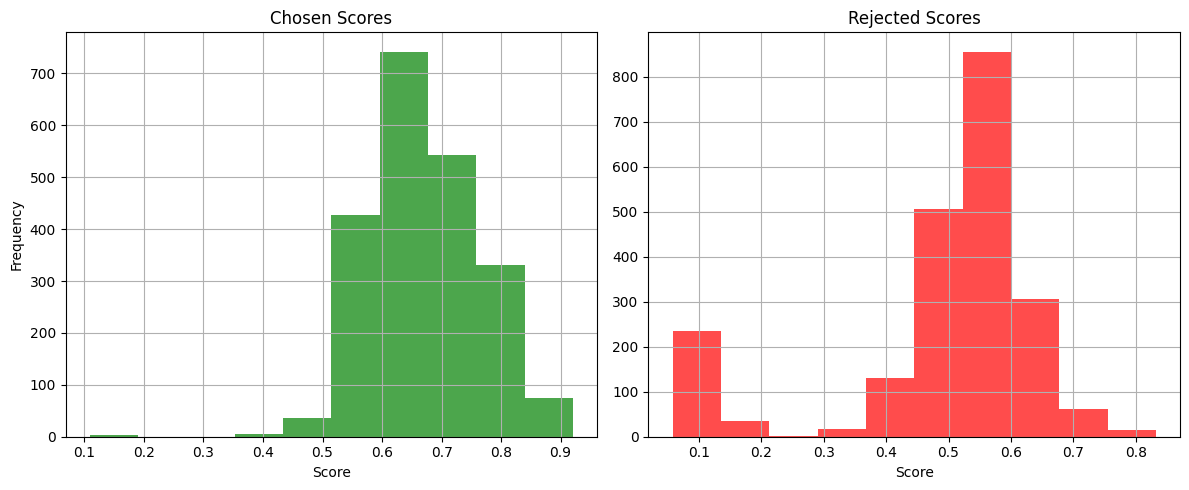

In [21]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms on each subplot
df.score_chosen.hist(ax=ax1, color='green', alpha=0.7)
ax1.set_title('Chosen Scores')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')

df.score_rejected.hist(ax=ax2, color='red', alpha=0.7)
ax2.set_title('Rejected Scores')
ax2.set_xlabel('Score')

# Adjust layout and display
plt.tight_layout()
plt.show()


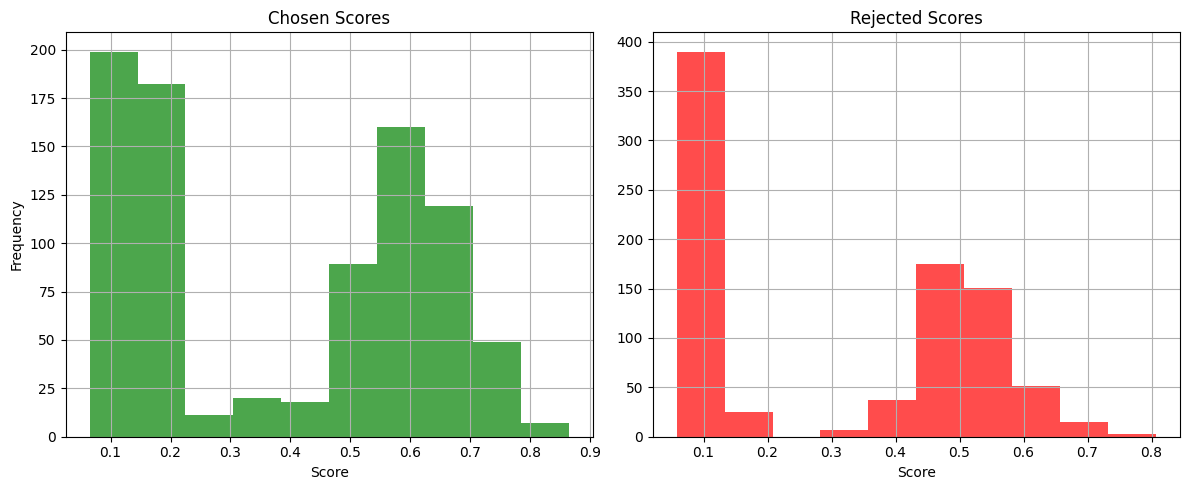

In [22]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms on each subplot
focus_df.score_chosen.hist(ax=ax1, color='green', alpha=0.7)
ax1.set_title('Chosen Scores')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')

focus_df.score_rejected.hist(ax=ax2, color='red', alpha=0.7)
ax2.set_title('Rejected Scores')
ax2.set_xlabel('Score')

# Adjust layout and display
plt.tight_layout()
plt.show()